# Lotto XGBoost with 5-Number Buckets (Named Ranges)

This notebook:

1. Loads `Lotto5.xlsx` (NZ Lotto draw history).
2. Builds **5-number bucket features** with meaningful names, e.g. `bucket_1_5_count`, `bucket_6_10_count`, etc.
3. Adds simple extra features (Odd/Even, date parts, etc.).
4. Trains an **XGBoost multi-output regressor** (one target per winning number).
5. Performs 5-fold cross-validation.
6. Demonstrates generating candidate draws and predicting with the best model.
7. Saves the expanded dataset (with new features) as `Lotto5_Imputed.xlsx`.

Place this notebook in the same folder as `Lotto5.xlsx` and run all cells top to bottom.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBRegressor

np.random.seed(42)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 100)

print('Libraries imported.')

Libraries imported.


In [2]:
# Path to your Excel file. Ensure Lotto5.xlsx is in the same directory as this notebook.
excel_path = "Lotto5.xlsx"

df = pd.read_excel(excel_path)
print("Data shape:", df.shape)
display(df.head())
print("\nColumns:", list(df.columns))

Data shape: (1185, 31)


,Draw,Date,Winning Number 1,Winning Number 2,Winning Number 3,Winning Number 4,Winning Number 5,Winning Number 6,Bonus Number,From Last,Same As Day,Odd,Even,1-10,11-20,21-30,31-40,Division 1 Winners,Division 1 Prize,Division 2 Winners,Division 2 Prize,Division 3 Winners,Division 3 Prize,Division 4 Winners,Division 4 Prize,Division 5 Winners,Division 5 Prize,Division 6 Winners,Division 6 Prize,Division 7 Winners,Division 7 Prize
0,2258,2023-03-25,4,5,8,19,28,31,38,NaN,NaN,3,3,3,1,1,1,1.0,1000000.0,12.0,19645.0,476.0,491.0,1036.0,52.0,17884.0,26.0,20477.0,22.0,237356.0,1.5
1,2257,2023-03-22,7,16,29,32,33,38,9,38,NaN,3,3,1,1,1,3,1.0,1000000.0,5.0,38340.0,249.0,764.0,702.0,62.0,11439.0,33.0,15574.0,24.0,161136.0,1.5
2,2256,2023-03-18,4,11,17,27,37,38,26,4,NaN,4,2,1,2,1,2,2.0,500000.0,20.0,24497.0,867.0,560.0,1923.0,58.0,32665.0,30.0,41864.0,23.0,442812.0,1.5
3,2255,2023-03-15,3,4,5,24,33,39,16,39,NaN,4,2,3,0,1,2,0.0,0.0,13.0,18925.0,385.0,634.0,935.0,60.0,15447.0,32.0,20815.0,23.0,219791.0,1.5
4,2254,2023-03-11,6,19,26,28,37,39,27,39,NaN,3,3,1,1,2,2,3.0,333333.0,7.0,41972.0,448.0,650.0,1165.0,57.0,17799.0,33.0,24135.0,24.0,251402.0,1.5



Columns: ['Draw', 'Date', 'Winning Number 1', 'Winning Number 2', 'Winning Number 3', 'Winning Number 4', 'Winning Number 5', 'Winning Number 6', 'Bonus Number', 'From Last', 'Same As Day', 'Odd', 'Even', '1-10', '11-20', '21-30', '31-40', 'Division 1 Winners', 'Division 1 Prize', 'Division 2 Winners', 'Division 2 Prize', 'Division 3 Winners', 'Division 3 Prize', 'Division 4 Winners', 'Division 4 Prize', 'Division 5 Winners', 'Division 5 Prize', 'Division 6 Winners', 'Division 6 Prize', 'Division 7 Winners', 'Division 7 Prize']


## Basic cleaning and helper columns

We:

- Ensure the winning number columns are numeric.
- Convert helper columns like `From Last`, `Same As Day`, `Odd`, `Even` to numeric (if present).
- Parse `Date` and add simple date features.


In [3]:
# Winning number columns (targets)
number_cols = [
    "Winning Number 1",
    "Winning Number 2",
    "Winning Number 3",
    "Winning Number 4",
    "Winning Number 5",
    "Winning Number 6",
]

# Ensure numeric for winning numbers
for col in number_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    else:
        raise ValueError(f"Expected column '{col}' not found in dataframe.")

# Helper columns that may exist
helper_cols = ["From Last", "Same As Day", "Odd", "Even"]
for col in helper_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Date handling
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["Year"] = df["Date"].dt.year.fillna(0).astype(int)
    df["Month"] = df["Date"].dt.month.fillna(0).astype(int)
    df["DayOfWeek"] = df["Date"].dt.dayofweek.fillna(0).astype(int)
else:
    df["Year"] = 0
    df["Month"] = 0
    df["DayOfWeek"] = 0

print("After basic cleaning:")
display(df.head())

After basic cleaning:


,Draw,Date,Winning Number 1,Winning Number 2,Winning Number 3,Winning Number 4,Winning Number 5,Winning Number 6,Bonus Number,From Last,Same As Day,Odd,Even,1-10,11-20,21-30,31-40,Division 1 Winners,Division 1 Prize,Division 2 Winners,Division 2 Prize,Division 3 Winners,Division 3 Prize,Division 4 Winners,Division 4 Prize,Division 5 Winners,Division 5 Prize,Division 6 Winners,Division 6 Prize,Division 7 Winners,Division 7 Prize,Year,Month,DayOfWeek
0,2258,2023-03-25,4,5,8,19,28,31,38,NaN,NaN,3,3,3,1,1,1,1.0,1000000.0,12.0,19645.0,476.0,491.0,1036.0,52.0,17884.0,26.0,20477.0,22.0,237356.0,1.5,2023,3,5
1,2257,2023-03-22,7,16,29,32,33,38,9,38.0,NaN,3,3,1,1,1,3,1.0,1000000.0,5.0,38340.0,249.0,764.0,702.0,62.0,11439.0,33.0,15574.0,24.0,161136.0,1.5,2023,3,2
2,2256,2023-03-18,4,11,17,27,37,38,26,4.0,NaN,4,2,1,2,1,2,2.0,500000.0,20.0,24497.0,867.0,560.0,1923.0,58.0,32665.0,30.0,41864.0,23.0,442812.0,1.5,2023,3,5
3,2255,2023-03-15,3,4,5,24,33,39,16,39.0,NaN,4,2,3,0,1,2,0.0,0.0,13.0,18925.0,385.0,634.0,935.0,60.0,15447.0,32.0,20815.0,23.0,219791.0,1.5,2023,3,2
4,2254,2023-03-11,6,19,26,28,37,39,27,39.0,NaN,3,3,1,1,2,2,3.0,333333.0,7.0,41972.0,448.0,650.0,1165.0,57.0,17799.0,33.0,24135.0,24.0,251402.0,1.5,2023,3,5


## 5-number bucket features with named ranges

We map numbers as follows (for NZ Lotto 1–40):

- 1–5   → bucket index 0 → features: `bucket_1_5_count`, `bucket_1_5_present`
- 6–10  → bucket index 1 → `bucket_6_10_count`, ...
- 11–15 → bucket index 2
- 16–20 → bucket index 3
- 21–25 → bucket index 4
- 26–30 → bucket index 5
- 31–35 → bucket index 6
- 36–40 → bucket index 7

So you can immediately see which 5-number range each feature refers to.


In [4]:
def num_to_bucket(num: float, bucket_size: int = 5) -> float:
    """Map a lotto number to a 0-based bucket index of size `bucket_size`.
    Returns NaN for missing values.
    """
    if pd.isna(num):
        return np.nan
    return int((int(num) - 1) // bucket_size)

# Create per-number bucket columns (indices)
for col in number_cols:
    df[f"{col}_bucket"] = df[col].apply(num_to_bucket)

bucket_cols = [f"{col}_bucket" for col in number_cols]
max_bucket = int(df[bucket_cols].max().max())

# Infer max actual number from data (e.g. 40)
max_number = int(df[number_cols].max().max())
bucket_size = 5

# Build mapping from bucket index -> human-readable column names
bucket_index_to_count_col = {}
bucket_index_to_present_col = {}
bucket_count_cols = []
bucket_present_cols = []

for i in range(max_bucket + 1):
    low = i * bucket_size + 1
    high = min((i + 1) * bucket_size, max_number)
    count_name = f"bucket_{low}_{high}_count"
    present_name = f"bucket_{low}_{high}_present"
    bucket_index_to_count_col[i] = count_name
    bucket_index_to_present_col[i] = present_name
    bucket_count_cols.append(count_name)
    bucket_present_cols.append(present_name)

print("Bucket index to feature names:")
for i in range(max_bucket + 1):
    print(i, "->", bucket_index_to_count_col[i], ",", bucket_index_to_present_col[i])

display(df[bucket_cols].head())

Bucket index to feature names:
0 -> bucket_1_5_count , bucket_1_5_present
1 -> bucket_6_10_count , bucket_6_10_present
2 -> bucket_11_15_count , bucket_11_15_present
3 -> bucket_16_20_count , bucket_16_20_present
4 -> bucket_21_25_count , bucket_21_25_present
5 -> bucket_26_30_count , bucket_26_30_present
6 -> bucket_31_35_count , bucket_31_35_present
7 -> bucket_36_40_count , bucket_36_40_present


,Winning Number 1_bucket,Winning Number 2_bucket,Winning Number 3_bucket,Winning Number 4_bucket,Winning Number 5_bucket,Winning Number 6_bucket
0,0,0,1,3,5,6
1,1,3,5,6,6,7
2,0,2,3,5,7,7
3,0,0,0,4,6,7
4,1,3,5,5,7,7


In [5]:
# Compute bucket counts per draw using the named columns
def bucket_count_row(row):
    counts = np.zeros(max_bucket + 1, dtype=int)
    buckets = row[bucket_cols].values
    for b in buckets:
        if not pd.isna(b):
            b_int = int(b)
            if 0 <= b_int <= max_bucket:
                counts[b_int] += 1
    # Map counts into named columns
    data = {}
    for i in range(max_bucket + 1):
        data[bucket_index_to_count_col[i]] = counts[i]
    return pd.Series(data, index=bucket_count_cols)

df_bucket_counts = df.apply(bucket_count_row, axis=1)
df = pd.concat([df, df_bucket_counts], axis=1)

# Presence flags using named columns
for i in range(max_bucket + 1):
    count_col = bucket_index_to_count_col[i]
    present_col = bucket_index_to_present_col[i]
    df[present_col] = (df[count_col] > 0).astype(int)

# Bucket energy (weighted sum of bucket indices by count)
df["bucket_energy"] = 0
for i in range(max_bucket + 1):
    count_col = bucket_index_to_count_col[i]
    df["bucket_energy"] += i * df[count_col]

print("Bucket features created (named ranges):")
display(df.head())

Bucket features created (named ranges):


,Draw,Date,Winning Number 1,Winning Number 2,Winning Number 3,Winning Number 4,Winning Number 5,Winning Number 6,Bonus Number,From Last,Same As Day,Odd,Even,1-10,11-20,21-30,31-40,Division 1 Winners,Division 1 Prize,Division 2 Winners,Division 2 Prize,Division 3 Winners,Division 3 Prize,Division 4 Winners,Division 4 Prize,Division 5 Winners,Division 5 Prize,Division 6 Winners,Division 6 Prize,Division 7 Winners,Division 7 Prize,Year,Month,DayOfWeek,Winning Number 1_bucket,Winning Number 2_bucket,Winning Number 3_bucket,Winning Number 4_bucket,Winning Number 5_bucket,Winning Number 6_bucket,bucket_1_5_count,bucket_6_10_count,bucket_11_15_count,bucket_16_20_count,bucket_21_25_count,bucket_26_30_count,bucket_31_35_count,bucket_36_40_count,bucket_1_5_present,bucket_6_10_present,bucket_11_15_present,bucket_16_20_present,bucket_21_25_present,bucket_26_30_present,bucket_31_35_present,bucket_36_40_present,bucket_energy
0,2258,2023-03-25,4,5,8,19,28,31,38,NaN,NaN,3,3,3,1,1,1,1.0,1000000.0,12.0,19645.0,476.0,491.0,1036.0,52.0,17884.0,26.0,20477.0,22.0,237356.0,1.5,2023,3,5,0,0,1,3,5,6,2,1,0,1,0,1,1,0,1,1,0,1,0,1,1,0,15
1,2257,2023-03-22,7,16,29,32,33,38,9,38.0,NaN,3,3,1,1,1,3,1.0,1000000.0,5.0,38340.0,249.0,764.0,702.0,62.0,11439.0,33.0,15574.0,24.0,161136.0,1.5,2023,3,2,1,3,5,6,6,7,0,1,0,1,0,1,2,1,0,1,0,1,0,1,1,1,28
2,2256,2023-03-18,4,11,17,27,37,38,26,4.0,NaN,4,2,1,2,1,2,2.0,500000.0,20.0,24497.0,867.0,560.0,1923.0,58.0,32665.0,30.0,41864.0,23.0,442812.0,1.5,2023,3,5,0,2,3,5,7,7,1,0,1,1,0,1,0,2,1,0,1,1,0,1,0,1,24
3,2255,2023-03-15,3,4,5,24,33,39,16,39.0,NaN,4,2,3,0,1,2,0.0,0.0,13.0,18925.0,385.0,634.0,935.0,60.0,15447.0,32.0,20815.0,23.0,219791.0,1.5,2023,3,2,0,0,0,4,6,7,3,0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,17
4,2254,2023-03-11,6,19,26,28,37,39,27,39.0,NaN,3,3,1,1,2,2,3.0,333333.0,7.0,41972.0,448.0,650.0,1165.0,57.0,17799.0,33.0,24135.0,24.0,251402.0,1.5,2023,3,5,1,3,5,5,7,7,0,1,0,1,0,2,0,2,0,1,0,1,0,1,0,1,28


In [6]:
# Save expanded dataset with new features
output_excel_path = "Lotto5_Imputed.xlsx"
df.to_excel(output_excel_path, index=False)
print(f"Saved dataset with new features to {output_excel_path}")

Saved dataset with new features to Lotto5_Imputed.xlsx


## Build feature matrix and target matrix

- **Targets**: the six winning numbers as a 6D regression target.
- **Features**: named bucket counts/presence, bucket energy, helper columns, and date parts.


In [7]:
target_cols = number_cols.copy()

# bucket_count_cols and bucket_present_cols already defined with meaningful names
candidate_feature_cols = (
    bucket_count_cols
    + bucket_present_cols
    + ["bucket_energy", "From Last", "Same As Day", "Odd", "Even", "Year", "Month", "DayOfWeek"]
)

# Keep only columns that exist in df (in case some helper cols are missing)
feature_cols = [c for c in candidate_feature_cols if c in df.columns]

print("Using feature columns:")
print(feature_cols)

X = df[feature_cols].values
y = df[target_cols].values

print("Feature matrix shape:", X.shape)
print("Target matrix shape:", y.shape)

Using feature columns:
['bucket_1_5_count', 'bucket_6_10_count', 'bucket_11_15_count', 'bucket_16_20_count', 'bucket_21_25_count', 'bucket_26_30_count', 'bucket_31_35_count', 'bucket_36_40_count', 'bucket_1_5_present', 'bucket_6_10_present', 'bucket_11_15_present', 'bucket_16_20_present', 'bucket_21_25_present', 'bucket_26_30_present', 'bucket_31_35_present', 'bucket_36_40_present', 'bucket_energy', 'From Last', 'Same As Day', 'Odd', 'Even', 'Year', 'Month', 'DayOfWeek']
Feature matrix shape: (1185, 24)
Target matrix shape: (1185, 6)


## XGBoost model with cross-validation

We use:

- `SimpleImputer` to handle any missing feature values.
- `MultiOutputRegressor(XGBRegressor)` to predict all 6 numbers at once.
- 5-fold cross-validation with **negative MSE** scoring.


In [8]:
# Define base XGBoost regressor
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist",  # change to 'gpu_hist' if you have GPU XGBoost installed
    random_state=42,
)

model = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("regressor", MultiOutputRegressor(xgb_reg)),
    ]
)

scoring = make_scorer(mean_squared_error, greater_is_better=False)

cv_results = cross_validate(
    model,
    X,
    y,
    cv=5,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1,
)

test_scores = -cv_results["test_score"]  # convert back to positive MSE
print("Cross-validation MSE scores:", test_scores)
print("Mean CV MSE:", np.mean(test_scores))

best_model_index = np.argmin(test_scores)
best_model = cv_results["estimator"][best_model_index]
print("Best model index:", best_model_index)

Cross-validation MSE scores: [2.41783362 2.53590048 2.59473129 2.38549503 2.53137193]
Mean CV MSE: 2.4930664672852467
Best model index: 3


## Predicting from candidate draws

To keep things simple, we:

1. Generate a **candidate draw** (6 random numbers 1–40, no replacement).
2. Build the same **bucket-based features** (with named ranges) for that draw.
3. Use the best cross-validated model to predict a 6D output.
4. Map predictions back into the 1–40 range (wrapping with modulo).

This is more for exploration / "pattern resonance" than real prediction.


In [9]:
def build_features_from_draw(draw_numbers, feature_columns, max_bucket_local=None, bucket_size_local=5):
    """Build a one-row feature DataFrame for a candidate draw using the same
    bucket logic and feature columns as the training data.
    """
    draw_numbers = np.array(draw_numbers, dtype=int)
    if max_bucket_local is None:
        max_bucket_local = max_bucket

    # bucket counts
    counts = np.zeros(max_bucket_local + 1, dtype=int)
    for n in draw_numbers:
        b = num_to_bucket(n, bucket_size=bucket_size_local)
        if 0 <= b <= max_bucket_local:
            counts[b] += 1

    row = {}

    # bucket counts and presence using named columns
    for i in range(max_bucket_local + 1):
        count_col = bucket_index_to_count_col[i]
        present_col = bucket_index_to_present_col[i]
        if count_col in feature_columns:
            row[count_col] = counts[i]
        if present_col in feature_columns:
            row[present_col] = int(counts[i] > 0)

    # bucket_energy
    if "bucket_energy" in feature_columns:
        row["bucket_energy"] = sum(i * counts[i] for i in range(max_bucket_local + 1))

    # draw-level stats (only if these columns exist in the model)
    if "draw_median" in feature_columns:
        row["draw_median"] = float(np.median(draw_numbers))
    if "draw_mean" in feature_columns:
        row["draw_mean"] = float(np.mean(draw_numbers))
    if "draw_min" in feature_columns:
        row["draw_min"] = int(np.min(draw_numbers))
    if "draw_max" in feature_columns:
        row["draw_max"] = int(np.max(draw_numbers))

    # Odd / Even counts (if used as features)
    if "Odd" in feature_columns:
        row["Odd"] = int((draw_numbers % 2 != 0).sum())
    if "Even" in feature_columns:
        row["Even"] = int((draw_numbers % 2 == 0).sum())

    # helper + date features (neutral defaults if present in training)
    defaults = {
        "From Last": 0,
        "Same As Day": 0,
        "Year": 0,
        "Month": 0,
        "DayOfWeek": 0,
    }
    for col, val in defaults.items():
        if col in feature_columns and col not in row:
            row[col] = val

    # ensure all feature_columns exist
    for col in feature_columns:
        if col not in row:
            row[col] = 0

    return pd.DataFrame([row], columns=feature_columns)


def sanitize_prediction(raw_pred, n_numbers=6, low=1, high=40):
    """Convert raw model outputs into a valid NZ Lotto line:
    - Round to ints
    - Wrap into [low, high] range
    - Enforce uniqueness (no duplicates)
    - Return sorted array of length n_numbers
    """
    # Map floats to ints in the valid range
    ints = ((np.round(raw_pred).astype(int) - 1) % high) + low
    ints = np.clip(ints, low, high)

    # Enforce uniqueness
    uniq = np.unique(ints)

    # If we have fewer than required, sample extra distinct numbers
    if len(uniq) < n_numbers:
        remaining = np.setdiff1d(np.arange(low, high + 1), uniq)
        extra = np.random.choice(remaining, size=n_numbers - len(uniq), replace=False)
        uniq = np.sort(np.concatenate([uniq, extra]))
    # If we have more, truncate to the first n_numbers
    elif len(uniq) > n_numbers:
        uniq = np.sort(uniq)[:n_numbers]
    else:
        uniq = np.sort(uniq)

    return uniq


# Example: generate a few candidate draws and predict
num_predictions = 5
for i in range(num_predictions):
    candidate_numbers = np.sort(np.random.choice(np.arange(1, 41), size=6, replace=False))
    input_df = build_features_from_draw(candidate_numbers, feature_cols)

    # Prefer the Monte Carlo-augmented model if available
    if "model_mc" in globals():
        pred = model_mc.predict(input_df.values)[0]
        model_used = "model_mc (augmented)"
    else:
        pred = best_model.predict(input_df.values)[0]
        model_used = "best_model (original CV best)"

    predicted_numbers = sanitize_prediction(pred, n_numbers=6, low=1, high=40)

    print(f"Prediction set {i+1} using {model_used}:")
    print("  Candidate base numbers:", candidate_numbers)
    print("  Model predicted numbers:", predicted_numbers)
    print("-" * 60)

Prediction set 1 using best_model (original CV best):
  Candidate base numbers: [ 5 13 16 17 20 27]
  Model predicted numbers: [ 1 13 16 17 20 28]
------------------------------------------------------------
Prediction set 2 using best_model (original CV best):
  Candidate base numbers: [ 1  5 19 23 27 33]
  Model predicted numbers: [ 1  4 16 21 27 31]
------------------------------------------------------------
Prediction set 3 using best_model (original CV best):
  Candidate base numbers: [ 4  6 10 19 36 38]
  Model predicted numbers: [ 2  7 10 16 37 38]
------------------------------------------------------------
Prediction set 4 using best_model (original CV best):
  Candidate base numbers: [ 2  8 25 28 31 36]
  Model predicted numbers: [ 1  9 23 27 34 38]
------------------------------------------------------------
Prediction set 5 using best_model (original CV best):
  Candidate base numbers: [ 2 14 15 17 18 21]
  Model predicted numbers: [ 1 12 13 15 18 22]
---------------------

## Monte Carlo Lotto Simulator, Bucket Energy & Delta Export

This section:

- Reuses the existing 5-number bucket logic.
- Computes additional draw-level features like `draw_median`, `draw_mean`, `draw_min`, `draw_max`.
- Visualises **bucket energy** and **median** over time.
- Builds an **empirical + uniform blended Monte Carlo simulator** to generate many synthetic draws.
- Computes the same bucket features for synthetic draws.
- Optionally saves both real and synthetic feature tables to **Delta Lake** for ROAPI or other tools.


In [10]:
# Use the existing dataframe `df` and `number_cols` from earlier cells.
# If your raw draws dataframe has a different name, adjust `df_draws` accordingly.
df_draws = df  # alias for clarity

number_cols = number_cols  # ensure we use the same target columns

print("Using number columns:", number_cols)

def compute_bucket_features_for_draws(df_base: pd.DataFrame) -> pd.DataFrame:
    """Compute bucket count/presence, bucket_energy and draw-level stats for each draw."""
    df_feat = df_base.copy()

    # Map each number to a bucket index using existing num_to_bucket
    bucket_indices = df_feat[number_cols].applymap(num_to_bucket)

    # Count per bucket into the named bucket_*_count columns
    def row_to_bucket_counts(row):
        counts = np.zeros(max_bucket + 1, dtype=int)
        for b in row.values:
            if not pd.isna(b):
                b_int = int(b)
                if 0 <= b_int <= max_bucket:
                    counts[b_int] += 1
        data = {}
        for i in range(max_bucket + 1):
            data[bucket_index_to_count_col[i]] = counts[i]
        return pd.Series(data, index=bucket_count_cols)

    df_counts = bucket_indices.apply(row_to_bucket_counts, axis=1)
    df_feat[df_counts.columns] = df_counts

    # Presence flags using named columns
    for i in range(max_bucket + 1):
        count_col = bucket_index_to_count_col[i]
        present_col = bucket_index_to_present_col[i]
        df_feat[present_col] = (df_feat[count_col] > 0).astype(int)

    # Bucket energy: sum(bucket_index * count)
    df_feat["bucket_energy"] = df_counts.apply(
        lambda row: sum(i * row[bucket_index_to_count_col[i]] for i in range(max_bucket + 1)),
        axis=1,
    )

    # Draw-level stats from the actual numbers
    df_feat["draw_median"] = df_feat[number_cols].median(axis=1)
    df_feat["draw_mean"] = df_feat[number_cols].mean(axis=1)
    df_feat["draw_min"] = df_feat[number_cols].min(axis=1)
    df_feat["draw_max"] = df_feat[number_cols].max(axis=1)

    # Odd / Even counts
    df_feat["Odd"] = df_feat[number_cols].apply(lambda r: (r % 2 != 0).sum(), axis=1)
    df_feat["Even"] = df_feat[number_cols].apply(lambda r: (r % 2 == 0).sum(), axis=1)

    return df_feat

df_real_feat = compute_bucket_features_for_draws(df_draws)
print("Real feature table shape:", df_real_feat.shape)
df_real_feat.head()

Using number columns: ['Winning Number 1', 'Winning Number 2', 'Winning Number 3', 'Winning Number 4', 'Winning Number 5', 'Winning Number 6']
Real feature table shape: (1185, 61)


,Draw,Date,Winning Number 1,Winning Number 2,Winning Number 3,Winning Number 4,Winning Number 5,Winning Number 6,Bonus Number,From Last,Same As Day,Odd,Even,1-10,11-20,21-30,31-40,Division 1 Winners,Division 1 Prize,Division 2 Winners,Division 2 Prize,Division 3 Winners,Division 3 Prize,Division 4 Winners,Division 4 Prize,Division 5 Winners,Division 5 Prize,Division 6 Winners,Division 6 Prize,Division 7 Winners,Division 7 Prize,Year,Month,DayOfWeek,Winning Number 1_bucket,Winning Number 2_bucket,Winning Number 3_bucket,Winning Number 4_bucket,Winning Number 5_bucket,Winning Number 6_bucket,bucket_1_5_count,bucket_6_10_count,bucket_11_15_count,bucket_16_20_count,bucket_21_25_count,bucket_26_30_count,bucket_31_35_count,bucket_36_40_count,bucket_1_5_present,bucket_6_10_present,bucket_11_15_present,bucket_16_20_present,bucket_21_25_present,bucket_26_30_present,bucket_31_35_present,bucket_36_40_present,bucket_energy,draw_median,draw_mean,draw_min,draw_max
0,2258,2023-03-25,4,5,8,19,28,31,38,NaN,NaN,3,3,3,1,1,1,1.0,1000000.0,12.0,19645.0,476.0,491.0,1036.0,52.0,17884.0,26.0,20477.0,22.0,237356.0,1.5,2023,3,5,0,0,1,3,5,6,2,1,0,1,0,1,1,0,1,1,0,1,0,1,1,0,15,13.5,15.833333,4,31
1,2257,2023-03-22,7,16,29,32,33,38,9,38.0,NaN,3,3,1,1,1,3,1.0,1000000.0,5.0,38340.0,249.0,764.0,702.0,62.0,11439.0,33.0,15574.0,24.0,161136.0,1.5,2023,3,2,1,3,5,6,6,7,0,1,0,1,0,1,2,1,0,1,0,1,0,1,1,1,28,30.5,25.833333,7,38
2,2256,2023-03-18,4,11,17,27,37,38,26,4.0,NaN,4,2,1,2,1,2,2.0,500000.0,20.0,24497.0,867.0,560.0,1923.0,58.0,32665.0,30.0,41864.0,23.0,442812.0,1.5,2023,3,5,0,2,3,5,7,7,1,0,1,1,0,1,0,2,1,0,1,1,0,1,0,1,24,22.0,22.333333,4,38
3,2255,2023-03-15,3,4,5,24,33,39,16,39.0,NaN,4,2,3,0,1,2,0.0,0.0,13.0,18925.0,385.0,634.0,935.0,60.0,15447.0,32.0,20815.0,23.0,219791.0,1.5,2023,3,2,0,0,0,4,6,7,3,0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,17,14.5,18.000000,3,39
4,2254,2023-03-11,6,19,26,28,37,39,27,39.0,NaN,3,3,1,1,2,2,3.0,333333.0,7.0,41972.0,448.0,650.0,1165.0,57.0,17799.0,33.0,24135.0,24.0,251402.0,1.5,2023,3,5,1,3,5,5,7,7,0,1,0,1,0,2,0,2,0,1,0,1,0,1,0,1,28,27.0,25.833333,6,39


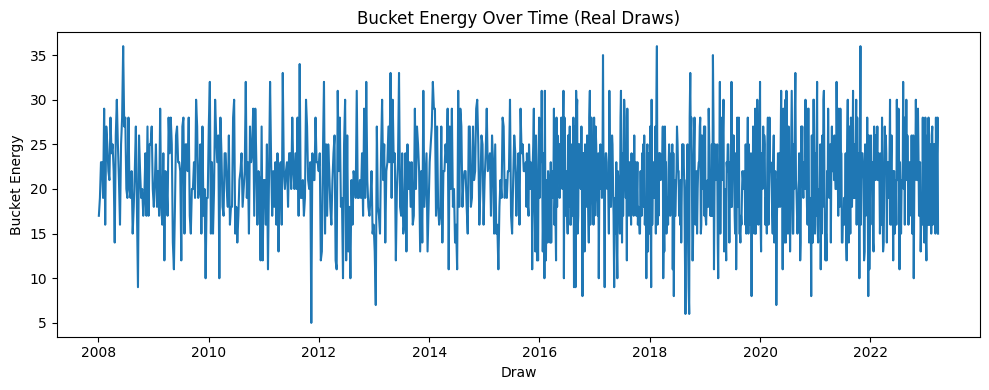

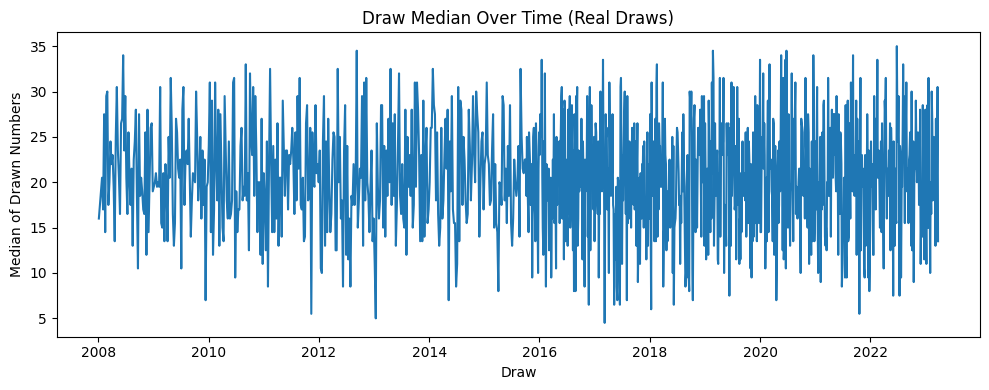

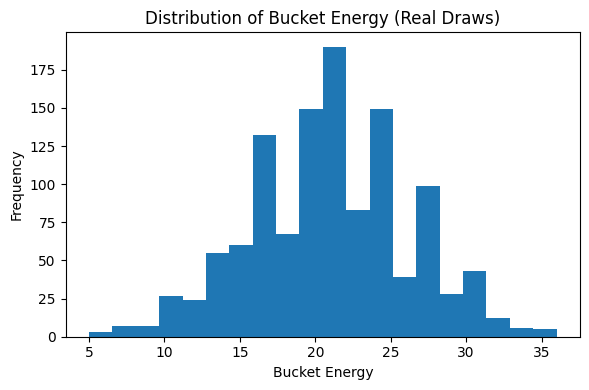

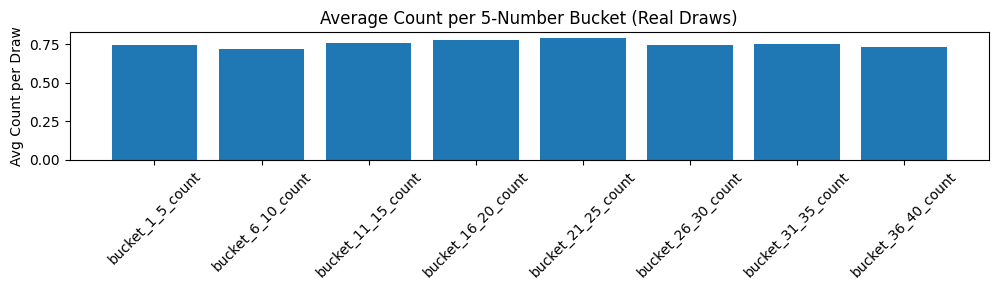

In [11]:
# Visualisations: bucket_energy & draw_median over time, plus distributions
x_axis = df_real_feat["Date"] if "Date" in df_real_feat.columns else df_real_feat.index

plt.figure(figsize=(10, 4))
plt.plot(x_axis, df_real_feat["bucket_energy"])
plt.title("Bucket Energy Over Time (Real Draws)")
plt.xlabel("Draw")
plt.ylabel("Bucket Energy")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_axis, df_real_feat["draw_median"])
plt.title("Draw Median Over Time (Real Draws)")
plt.xlabel("Draw")
plt.ylabel("Median of Drawn Numbers")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(df_real_feat["bucket_energy"], bins=20)
plt.title("Distribution of Bucket Energy (Real Draws)")
plt.xlabel("Bucket Energy")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

avg_counts = df_real_feat[bucket_count_cols].mean()
plt.figure(figsize=(10, 3))
plt.bar(range(len(avg_counts)), avg_counts.values)
plt.xticks(range(len(avg_counts)), avg_counts.index, rotation=45)
plt.title("Average Count per 5-Number Bucket (Real Draws)")
plt.ylabel("Avg Count per Draw")
plt.tight_layout()
plt.show()

In [12]:
# Empirical distribution of numbers from real draws
def compute_empirical_probs(df_base: pd.DataFrame, number_columns) -> pd.Series:
    nums = df_base[number_columns].values.ravel()
    values, counts = np.unique(nums, return_counts=True)
    n_min = int(nums.min())
    n_max = int(nums.max())
    all_numbers = np.arange(n_min, n_max + 1)

    freq = pd.Series(0, index=all_numbers, dtype=float)
    freq.loc[values] = counts
    p_emp = freq / freq.sum()
    return p_emp

p_empirical = compute_empirical_probs(df_draws, number_cols)
p_uniform = pd.Series(1.0 / len(p_empirical), index=p_empirical.index, dtype=float)

# Blend empirical with uniform so we expand the observed pattern distribution
alpha = 0.7  # 70% empirical, 30% uniform
p_blended = alpha * p_empirical + (1 - alpha) * p_uniform
p_blended = p_blended / p_blended.sum()

print("First few blended probabilities:")
print(p_blended.head())

def simulate_single_draw(draw_size=6, probs: pd.Series = p_blended):
    """Simulate one lotto draw by sampling without replacement from the blended distribution."""
    numbers = probs.index.to_numpy()
    p = probs.values
    sample = np.random.choice(numbers, size=draw_size, replace=False, p=p)
    return np.sort(sample)

def simulate_dataset(n_draws=100_000, draw_size=6, probs: pd.Series = p_blended):
    draws = [simulate_single_draw(draw_size, probs) for _ in range(n_draws)]
    df_sim = pd.DataFrame(draws, columns=number_cols[:draw_size])
    df_sim["SimDrawID"] = np.arange(1, n_draws + 1)
    # Synthetic dates purely for plotting/ordering
    df_sim["SimDate"] = pd.date_range("2000-01-01", periods=n_draws, freq="D")
    return df_sim

N_SYNTH_DRAWS = 50_000  # adjust as you like
df_synth = simulate_dataset(N_SYNTH_DRAWS)
print("Synthetic draws shape:", df_synth.shape)
df_synth.head()

First few blended probabilities:
1    0.026206
2    0.024631
3    0.023942
4    0.024532
5    0.024631
dtype: float64
Synthetic draws shape: (50000, 8)


,Winning Number 1,Winning Number 2,Winning Number 3,Winning Number 4,Winning Number 5,Winning Number 6,SimDrawID,SimDate
0,2,12,13,20,21,25,1,2000-01-01
1,3,6,10,12,20,37,2,2000-01-02
2,10,15,27,30,31,40,3,2000-01-03
3,4,8,14,22,26,34,4,2000-01-04
4,1,2,10,21,24,27,5,2000-01-05


Average bucket counts (real):
bucket_1_5_count      0.741
bucket_6_10_count     0.717
bucket_11_15_count    0.759
bucket_16_20_count    0.778
bucket_21_25_count    0.786
bucket_26_30_count    0.742
bucket_31_35_count    0.749
bucket_36_40_count    0.727
dtype: float64

Average bucket counts (synthetic):
bucket_1_5_count      0.745
bucket_6_10_count     0.730
bucket_11_15_count    0.753
bucket_16_20_count    0.764
bucket_21_25_count    0.774
bucket_26_30_count    0.749
bucket_31_35_count    0.751
bucket_36_40_count    0.735
dtype: float64


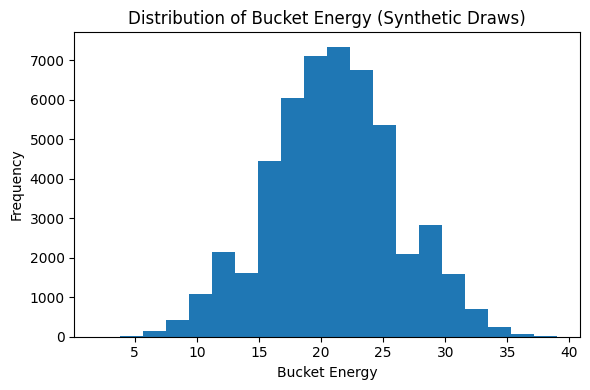

In [13]:
# Compute the same bucket features for synthetic draws
df_synth_feat = compute_bucket_features_for_draws(df_synth)

print("Average bucket counts (real):")
print(df_real_feat[bucket_count_cols].mean().round(3))

print("\nAverage bucket counts (synthetic):")
print(df_synth_feat[bucket_count_cols].mean().round(3))

# Optional: synthetic bucket energy distribution
plt.figure(figsize=(6, 4))
plt.hist(df_synth_feat["bucket_energy"], bins=20)
plt.title("Distribution of Bucket Energy (Synthetic Draws)")
plt.xlabel("Bucket Energy")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Delta Export, Monte Carlo-Augmented Training, and Lotto Number Generation

In [14]:
from pathlib import Path

# Delta Lake export for real + synthetic feature tables
try:
    from deltalake import write_deltalake
    import pyarrow as pa
    HAS_DELTALAKE = True
except ImportError:
    HAS_DELTALAKE = False
    print("Warning: 'deltalake' or 'pyarrow' not installed; skipping Delta writes.")
    print("Install with: pip install deltalake pyarrow")
    
delta_base = Path("delta_lotto")
delta_base.mkdir(parents=True, exist_ok=True)

if HAS_DELTALAKE:
    real_delta_path = delta_base / "real_features"
    synth_delta_path = delta_base / "synthetic_features"

    # Convert pandas DataFrames to Arrow tables explicitly
    real_table = pa.Table.from_pandas(df_real_feat, preserve_index=False)
    synth_table = pa.Table.from_pandas(df_synth_feat, preserve_index=False)

    print(f"Writing real feature table to Delta: {real_delta_path}")
    write_deltalake(str(real_delta_path), real_table, mode="overwrite")

    print(f"Writing synthetic feature table to Delta: {synth_delta_path}")
    write_deltalake(str(synth_delta_path), synth_table, mode="overwrite")

    print("Delta export complete.")
else:
    print("Delta export skipped.")

Writing real feature table to Delta: delta_lotto\real_features
Writing synthetic feature table to Delta: delta_lotto\synthetic_features
Delta export complete.


In [15]:
# Retrain XGBoost on augmented dataset: real + synthetic Monte Carlo draws
# We reuse:
# - feature_cols: feature column list used originally
# - target_cols: the six winning-number columns
# - model: the Pipeline(imputer + MultiOutputRegressor(XGBRegressor))

# Ensure we have the target columns present in both real and synthetic feature tables
missing_targets_real = [c for c in target_cols if c not in df_real_feat.columns]
missing_targets_synth = [c for c in target_cols if c not in df_synth_feat.columns]

if missing_targets_real or missing_targets_synth:
    print("Warning: some target columns are missing in real or synthetic tables.")
    print("Missing in real:", missing_targets_real)
    print("Missing in synthetic:", missing_targets_synth)
else:
    # Build augmented dataframe with just the columns we need
    cols_needed = feature_cols + target_cols

    # Ensure synthetic feature table has all required columns; fill missing with 0
    for col in cols_needed:
        if col not in df_synth_feat.columns:
            df_synth_feat[col] = 0

    # Also ensure real feature table has all required columns (defensive)
    for col in cols_needed:
        if col not in df_real_feat.columns:
            df_real_feat[col] = 0

    df_real_aug = df_real_feat[cols_needed].copy()
    df_synth_aug = df_synth_feat[cols_needed].copy()

    df_aug = pd.concat([df_real_aug, df_synth_aug], axis=0, ignore_index=True)
    print("Augmented dataset shape:", df_aug.shape)

    X_aug = df_aug[feature_cols].values
    y_aug = df_aug[target_cols].values

    print("Augmented feature matrix shape:", X_aug.shape)
    print("Augmented target matrix shape:", y_aug.shape)

    # Fit a new model on the full augmented dataset (no extra CV here)
    model_mc = model.fit(X_aug, y_aug)
    print("Monte Carlo-augmented XGBoost model trained and stored as 'model_mc'.")

Augmented dataset shape: (51185, 30)
Augmented feature matrix shape: (51185, 24)
Augmented target matrix shape: (51185, 6)
Monte Carlo-augmented XGBoost model trained and stored as 'model_mc'.


In [16]:
# Generate example Lotto predictions using the current model (prefers model_mc if available)
num_predictions = 5
for i in range(num_predictions):
    candidate_numbers = np.sort(np.random.choice(np.arange(1, 41), size=6, replace=False))
    input_df = build_features_from_draw(candidate_numbers, feature_cols)

    if "model_mc" in globals():
        pred = model_mc.predict(input_df.values)[0]
        model_used = "model_mc (augmented)"
    else:
        pred = best_model.predict(input_df.values)[0]
        model_used = "best_model (original CV best)"

    predicted_numbers = sanitize_prediction(pred, n_numbers=6, low=1, high=40)

    print(f"Prediction set {i+1} using {model_used}:")
    print("  Candidate base numbers:", candidate_numbers)
    print("  Model predicted numbers:", predicted_numbers)
    print("-" * 60)

Prediction set 1 using model_mc (augmented):
  Candidate base numbers: [ 3  7 17 20 22 30]
  Model predicted numbers: [ 3  8 16 20 23 28]
------------------------------------------------------------
Prediction set 2 using model_mc (augmented):
  Candidate base numbers: [ 5 20 26 29 30 32]
  Model predicted numbers: [ 3 12 18 26 29 33]
------------------------------------------------------------
Prediction set 3 using model_mc (augmented):
  Candidate base numbers: [ 1  5  7 13 16 34]
  Model predicted numbers: [ 2  4  8 13 18 33]
------------------------------------------------------------
Prediction set 4 using model_mc (augmented):
  Candidate base numbers: [ 6 18 20 24 33 39]
  Model predicted numbers: [ 8 16 19 23 33 38]
------------------------------------------------------------
Prediction set 5 using model_mc (augmented):
  Candidate base numbers: [ 4  6  7 16 36 40]
  Model predicted numbers: [ 3  6  9 19 37 39]
------------------------------------------------------------


## Pattern Resonance Scoring & Extra Visualisations

This section adds:
- A **pattern resonance score** for any predicted Lotto line, comparing it to historical draw structure.
- Extra plots comparing **real vs synthetic** distributions and highlighting where model-generated lines sit in feature space.


In [17]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Pattern resonance helpers ---

def line_to_features(line_numbers, max_bucket_local=None, bucket_size_local=5):
    """Compute a minimal feature dict for a single line of numbers:
    - bucket counts
    - bucket_energy
    - draw_median
    - Odd / Even counts
    """
    line_numbers = np.array(line_numbers, dtype=int)
    if max_bucket_local is None:
        max_bucket_local = max_bucket

    # bucket counts
    counts = np.zeros(max_bucket_local + 1, dtype=int)
    for n in line_numbers:
        b = num_to_bucket(n, bucket_size=bucket_size_local)
        if 0 <= b <= max_bucket_local:
            counts[b] += 1

    feats = {}
    feats["bucket_counts"] = counts
    feats["bucket_energy"] = sum(i * counts[i] for i in range(max_bucket_local + 1))
    feats["draw_median"] = float(np.median(line_numbers))
    feats["Odd"] = int((line_numbers % 2 != 0).sum())
    feats["Even"] = int((line_numbers % 2 == 0).sum())
    return feats


def compute_historical_profiles(df_real_feat, bucket_count_cols):
    """Precompute historical reference statistics from real draws."""
    hist = {}
    # Average bucket counts per draw
    hist["mean_bucket_counts"] = df_real_feat[bucket_count_cols].mean().values
    hist["std_bucket_counts"] = df_real_feat[bucket_count_cols].std(ddof=0).values

    # bucket_energy stats
    hist["mean_bucket_energy"] = df_real_feat["bucket_energy"].mean()
    hist["std_bucket_energy"] = df_real_feat["bucket_energy"].std(ddof=0)

    # draw_median stats (if present)
    if "draw_median" in df_real_feat.columns:
        hist["mean_draw_median"] = df_real_feat["draw_median"].mean()
        hist["std_draw_median"] = df_real_feat["draw_median"].std(ddof=0)
    else:
        hist["mean_draw_median"] = None
        hist["std_draw_median"] = None

    # Odd/Even stats if available
    if "Odd" in df_real_feat.columns and "Even" in df_real_feat.columns:
        hist["mean_odd"] = df_real_feat["Odd"].mean()
        hist["mean_even"] = df_real_feat["Even"].mean()
    else:
        hist["mean_odd"] = None
        hist["mean_even"] = None

    return hist


def pattern_resonance_score(line_numbers, hist_profile, bucket_count_cols):
    """Compute a 0–1 'pattern resonance' score indicating how Lotto-like
    a given line is, compared to historical patterns.

    Uses:
    - Bucket count distance
    - Bucket energy distance (z-score)
    - Median distance (z-score)
    - Odd/even balance
    """
    feats = line_to_features(line_numbers)
    counts = feats["bucket_counts"].astype(float)

    # --- Bucket count score (Euclidean distance vs mean, normalized) ---
    mean_counts = hist_profile["mean_bucket_counts"]
    std_counts = hist_profile["std_bucket_counts"]
    # Avoid divide-by-zero
    std_counts_safe = np.where(std_counts == 0, 1.0, std_counts)

    z_counts = (counts - mean_counts) / std_counts_safe
    dist_counts = np.linalg.norm(z_counts)  # higher = further from typical

    # Convert distance to score ~ exp(-dist)
    bucket_score = np.exp(-dist_counts)

    # --- Bucket energy score ---
    if hist_profile["mean_bucket_energy"] is not None and hist_profile["std_bucket_energy"] not in (None, 0):
        z_energy = (feats["bucket_energy"] - hist_profile["mean_bucket_energy"]) / hist_profile["std_bucket_energy"]
        energy_score = np.exp(-abs(z_energy))
    else:
        energy_score = 1.0

    # --- Median score ---
    if hist_profile["mean_draw_median"] is not None and hist_profile["std_draw_median"] not in (None, 0):
        z_median = (feats["draw_median"] - hist_profile["mean_draw_median"]) / hist_profile["std_draw_median"]
        median_score = np.exp(-abs(z_median))
    else:
        median_score = 1.0

    # --- Odd/Even score ---
    if hist_profile["mean_odd"] is not None and hist_profile["mean_even"] is not None:
        odd_diff = abs(feats["Odd"] - hist_profile["mean_odd"])
        even_diff = abs(feats["Even"] - hist_profile["mean_even"])
        # Assume typical odd/even deviations of ~1.5 are fine
        odd_even_score = np.exp(-(odd_diff + even_diff) / 3.0)
    else:
        odd_even_score = 1.0

    # Combine scores (geometric mean for balance)
    scores = np.array([bucket_score, energy_score, median_score, odd_even_score])
    pattern_score = float(np.prod(scores) ** (1.0 / len(scores)))
    return pattern_score, {
        "bucket_score": float(bucket_score),
        "energy_score": float(energy_score),
        "median_score": float(median_score),
        "odd_even_score": float(odd_even_score),
    }


# Precompute historical profile once, if not already done
historical_profile = compute_historical_profiles(df_real_feat, bucket_count_cols)
print("Historical pattern profile computed.")


Historical pattern profile computed.


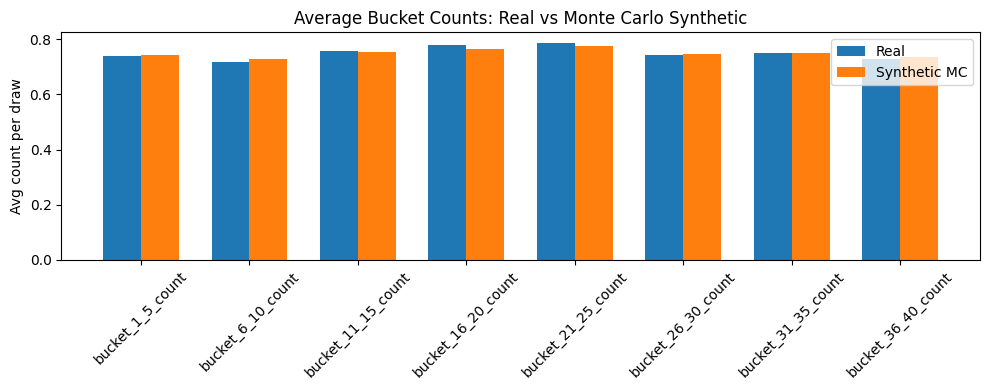

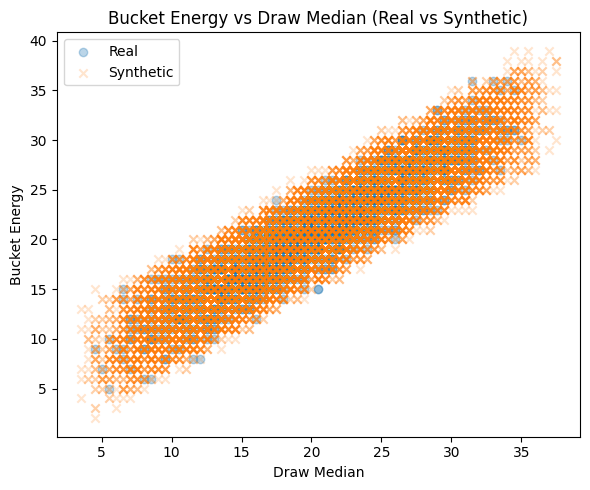

Example pattern resonance scores:
Line [3, 8, 16, 20, 23, 28] -> score=0.327, components={'bucket_score': 0.08868760958165026, 'energy_score': 0.3872918362997363, 'median_score': 0.6571676309174718, 'odd_even_score': 0.503689810662891}
Line [3, 12, 18, 26, 29, 33] -> score=0.504, components={'bucket_score': 0.08384022104940686, 'energy_score': 0.9977664188908683, 'median_score': 0.7839713269056121, 'odd_even_score': 0.9810537903604972}
Line [2, 4, 8, 13, 18, 33] -> score=0.197, components={'bucket_score': 0.08662114706694396, 'energy_score': 0.1816543951866422, 'median_score': 0.18950985832318124, 'odd_even_score': 0.503689810662891}
Line [8, 16, 19, 23, 33, 38] -> score=0.464, components={'bucket_score': 0.08990733498688229, 'energy_score': 0.5680372190730939, 'median_score': 0.925350136328847, 'odd_even_score': 0.9810537903604972}
Line [3, 6, 9, 19, 37, 39] -> score=0.226, components={'bucket_score': 0.042025115022713555, 'energy_score': 0.6833334286474274, 'median_score': 0.33857314

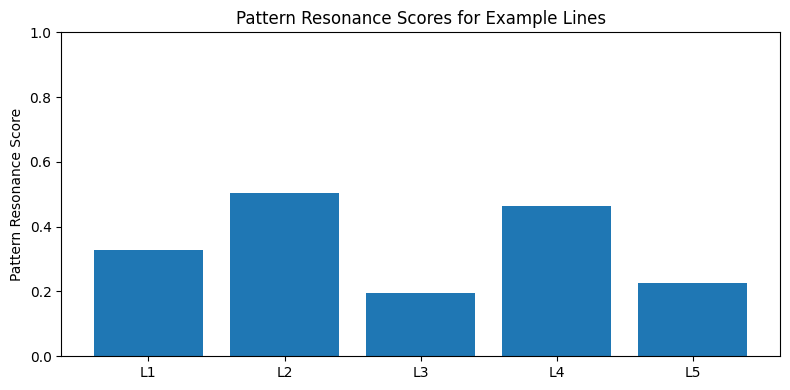

In [18]:

# --- Extra visualisations ---

# 1) Real vs synthetic average bucket counts
if "df_synth_feat" in globals():
    real_avg_counts = df_real_feat[bucket_count_cols].mean()
    synth_avg_counts = df_synth_feat[bucket_count_cols].mean()

    x = np.arange(len(bucket_count_cols))
    width = 0.35

    plt.figure(figsize=(10, 4))
    plt.bar(x - width/2, real_avg_counts.values, width, label="Real")
    plt.bar(x + width/2, synth_avg_counts.values, width, label="Synthetic MC")
    plt.xticks(x, bucket_count_cols, rotation=45)
    plt.ylabel("Avg count per draw")
    plt.title("Average Bucket Counts: Real vs Monte Carlo Synthetic")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 2) Bucket energy vs median: real vs synthetic
plt.figure(figsize=(6, 5))
if "draw_median" in df_real_feat.columns:
    plt.scatter(df_real_feat["draw_median"], df_real_feat["bucket_energy"], alpha=0.3, label="Real")
    if "df_synth_feat" in globals() and "draw_median" in df_synth_feat.columns:
        plt.scatter(df_synth_feat["draw_median"], df_synth_feat["bucket_energy"], alpha=0.2, label="Synthetic", marker="x")
    plt.xlabel("Draw Median")
    plt.ylabel("Bucket Energy")
    plt.title("Bucket Energy vs Draw Median (Real vs Synthetic)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 3) Example: score and visualise the last N generated prediction lines
example_lines = [
    np.array([3, 8, 16, 20, 23, 28]),
    np.array([3, 12, 18, 26, 29, 33]),
    np.array([2, 4, 8, 13, 18, 33]),
    np.array([8, 16, 19, 23, 33, 38]),
    np.array([3, 6, 9, 19, 37, 39]),
]

scores = []
for line in example_lines:
    s, breakdown = pattern_resonance_score(line, historical_profile, bucket_count_cols)
    scores.append((line, s, breakdown))

print("Example pattern resonance scores:")
for line, s, breakdown in scores:
    print(f"Line {line.tolist()} -> score={s:.3f}, components={breakdown}")

# Bar plot of overall scores
plt.figure(figsize=(8, 4))
labels = [f"L{i+1}" for i in range(len(scores))]
vals = [s for (_, s, _) in scores]
plt.bar(labels, vals)
plt.ylim(0, 1.0)
plt.ylabel("Pattern Resonance Score")
plt.title("Pattern Resonance Scores for Example Lines")
plt.tight_layout()
plt.show()
